In [1]:
import pandas as pd
import numpy as np
import random
import datetime

from sklearn.preprocessing import RobustScaler, MinMaxScaler, PolynomialFeatures, Normalizer
from sklearn.model_selection import train_test_split
import torch
import torch.utils.data as data_torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from ydata_profiling import ProfileReport # подробный разбор признаков

In [2]:
data_patch = '.\\'

In [3]:
def stratify_data(filename):
    
    dataframe = pd.read_csv(filename).copy()
    dataframe = dataframe.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
    mask = dataframe['Age'].isna()
    dataframe.loc[mask, 'Age'] = np.random.randint(10, 50, mask.sum())
    dataframe['Embarked'] = dataframe['Embarked'].fillna(dataframe['Embarked'].mode()[0])
    dataframe['Sex'] = dataframe['Sex'].map({'male':1,'female':0})
    dataframe['Embarked'] = dataframe['Embarked'].map({'S':0,'C':1, 'Q':2})
    
    survived = dataframe['Survived']
    #survived = pd.concat([survived, survived.copy()], ignore_index=True)
    features = dataframe.drop(['Survived'], axis=1)
    
    features = pd.get_dummies(features, columns=['Pclass', 'SibSp', 'Parch', 'Embarked'], dtype=int)
    #poly = PolynomialFeatures(degree=2, include_bias=False)
    #features = poly.fit_transform(features)
        
    #features = RobustScaler().fit_transform(features)
    features = MinMaxScaler().fit_transform(features)
    #features = Normalizer().fit_transform(features)
    
    data_scaled = pd.DataFrame(data=features)
    #data_scaled = pd.concat([data_scaled, data_scaled.copy()], ignore_index=True)
    
    X_train, X_val, y_train, y_val = train_test_split(data_scaled, survived, test_size=0.2, random_state=2, stratify=survived)
    
    X_train['Survived'] = y_train
    X_val['Survived'] = y_val
    
    X_train.to_csv('train_data.csv', sep=',', index=False)
    X_val.to_csv('val_data.csv', sep=',', index=False)

In [4]:
stratify_data(data_patch + 'train.csv')

In [5]:
class TitanicDataset(data_torch.Dataset):
    
    def __init__(self, filename, Train=True):
        self.dataframe = pd.read_csv(filename).copy()
                      
        self.Train = Train
        
    def __len__(self):
        return self.dataframe.shape[0]
    
    def __getitem__(self, idx):
        if(self.Train):
            survived = self.dataframe['Survived']
            survived = np.array(survived)[idx]
            
        features = self.dataframe.drop(['Survived'], axis=1)
        features = np.array(features)[idx]
                
        if(self.Train):
            return features, survived
        else:
            return features
          
    def infoo(self):
        return self.dataframe.info()

In [6]:
train_dataset = TitanicDataset(data_patch + 'train_data.csv')
val_dataset = TitanicDataset(data_patch + 'val_data.csv')
testing_dataset = TitanicDataset(data_patch + 'test.csv', Train=False)

In [7]:
train_dataset.__getitem__(5)

(array([0.        , 0.33400352, 0.0270496 , 0.        , 1.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        ]),
 1)

In [8]:
train_dataset.infoo()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 712 entries, 0 to 711
Data columns (total 24 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   0         712 non-null    float64
 1   1         712 non-null    float64
 2   2         712 non-null    float64
 3   3         712 non-null    float64
 4   4         712 non-null    float64
 5   5         712 non-null    float64
 6   6         712 non-null    float64
 7   7         712 non-null    float64
 8   8         712 non-null    float64
 9   9         712 non-null    float64
 10  10        712 non-null    float64
 11  11        712 non-null    float64
 12  12        712 non-null    float64
 13  13        712 non-null    float64
 14  14        712 non-null    float64
 15  15        712 non-null    float64
 16  16        712 non-null    float64
 17  17        712 non-null    float64
 18  18        712 non-null    float64
 19  19        712 non-null    float64
 20  20        712 non-null    float6

In [9]:
train_dataload = data_torch.DataLoader(train_dataset, shuffle=True, batch_size=100)
t = iter(train_dataload)
print(next(t))

[tensor([[1.0000, 0.3843, 0.0586,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.2083, 0.0155,  ..., 1.0000, 0.0000, 0.0000],
        [1.0000, 0.2837, 0.0254,  ..., 1.0000, 0.0000, 0.0000],
        ...,
        [1.0000, 0.3466, 0.1103,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.2963, 0.0283,  ..., 1.0000, 0.0000, 0.0000],
        [1.0000, 0.2837, 0.0580,  ..., 0.0000, 1.0000, 0.0000]],
       dtype=torch.float64), tensor([1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
        1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 1])]


In [10]:
val_dataload = data_torch.DataLoader(val_dataset, shuffle=True, batch_size=100)
t = iter(val_dataload)
print(next(t))

[tensor([[1.0000, 0.7235, 0.2211,  ..., 0.0000, 1.0000, 0.0000],
        [1.0000, 0.5979, 0.0423,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0450, 0.0262,  ..., 0.0000, 1.0000, 0.0000],
        ...,
        [1.0000, 0.2963, 0.0138,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0576, 0.0542,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.4974, 0.0307,  ..., 1.0000, 0.0000, 0.0000]],
       dtype=torch.float64), tensor([0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0,
        1, 0, 1, 1])]


In [11]:
class Net(nn.Module):
    
    def __init__(self, col, a, b):
        super(Net, self).__init__()
        self.dl1 = nn.Linear(col, a)
        self.dl2 = nn.Linear(a, b)
        self.dl3 = nn.Linear(b, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.dl1(x))
        x = F.relu(self.dl2(x))
        x = self.sigmoid(self.dl3(x))
        return x

class Net(nn.Module):
    def __init__(self, col, a, b):
        super(Net, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(col, a),
            nn.BatchNorm1d(a),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(a, b),
            nn.BatchNorm1d(b),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(b, a),
            nn.BatchNorm1d(a),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(a, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

class Net(nn.Module):
    def __init__(self, col, a, b, c, d):
        super(Net, self).__init__()
        self.b1 = nn.Sequential(
            nn.Linear(in_features=col,out_features=a),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(a),
            nn.Linear(in_features=a,out_features=b),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.BatchNorm1d(b),
            nn.Linear(in_features=b,out_features=c),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.BatchNorm1d(c),
            nn.Linear(in_features=c,out_features=d),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.BatchNorm1d(d),
            nn.Linear(in_features=d,out_features=int(d/2)),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(int(d/2)),
            nn.Linear(in_features=int(d/2),out_features=c),
            nn.ReLU(),
            nn.BatchNorm1d(c),
            nn.Linear(in_features=c,out_features=1),
            nn.Sigmoid()
        )
    def forward(self,x):
        x = self.b1(x)
        return x

In [12]:
size_columns = len(next(iter(train_dataload))[0][0])
hidden_layer1_coeff = 15
hidden_layer2_coeff = 7
hidden_layer3_coeff = 3.5
hidden_layer4_coeff = 2
lr = 0.01
momentum = 0.9
epochs = 100
hidden_layer1 = round(hidden_layer1_coeff * size_columns)
hidden_layer2 = round(hidden_layer2_coeff * size_columns)
hidden_layer3 = round(hidden_layer3_coeff * size_columns)
hidden_layer4 = round(hidden_layer4_coeff * size_columns)

In [13]:
net = Net(size_columns, hidden_layer1, hidden_layer2)

#net = Net(size_columns, hidden_layer1, hidden_layer2, hidden_layer3, hidden_layer4)
print(net)


Net(
  (dl1): Linear(in_features=23, out_features=345, bias=True)
  (dl2): Linear(in_features=345, out_features=161, bias=True)
  (dl3): Linear(in_features=161, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


net = Net(size_columns, hidden_layer1, hidden_layer2)
print(net)

In [14]:
#optimizer = optim.SGD(net.parameters(), lr = lr, momentum = momentum)
optimizer = optim.Adam(net.parameters(), lr = lr)
criterion = nn.BCELoss()

In [15]:
def train(model, training_data, optimizer, criterion, epochs=10):
    dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(dev)
    losses = []
    accuracy = []
    for epoch in range(epochs):
        running_loss = 0.0
        batch = 0
        model.train()
        for  X, y in training_data:
            X , y = X.to(dev) , y.to(dev)
            features = len(next(iter(training_data))[0][0])
            #X = X.view(-1, features)
            y = y.view(-1, 1)
            
            optimizer.zero_grad()
            
            prob_y = model(X.float())
            
            y_pred = (prob_y > torch.Tensor([0.5])).long().squeeze()
            
            accuracy.append((y_pred==y).sum().item()/len(y_pred))
            
            loss = criterion(prob_y, y.float())
            
            loss.backward()
            
            optimizer.step()
            
            running_loss += loss.item()
            
            batch += 1
        # средние потери на каждой эпохе    
        losses.append(running_loss/batch)
        if epoch%5==0:
            print('epochs {} done'.format(epoch+5))
    model.eval()
    print("Fin")
    return (losses, accuracy)

In [16]:
losses, accuracy = train(net, train_dataload, optimizer, criterion, epochs=epochs)

epochs 5 done
epochs 10 done
epochs 15 done
epochs 20 done
epochs 25 done
epochs 30 done
epochs 35 done
epochs 40 done
epochs 45 done
epochs 50 done
epochs 55 done
epochs 60 done
epochs 65 done
epochs 70 done
epochs 75 done
epochs 80 done
epochs 85 done
epochs 90 done
epochs 95 done
epochs 100 done
Fin


In [17]:
def plot_loss_acc(losses, accuracy):
    figure = plt.figure(figsize=(9,3))
    plt.subplot(121, title="losses")
    plt.plot(range(1, len(losses)+1), losses)
    plt.xlabel("epoch №")
    plt.ylabel("loss")
    plt.subplot(122, title="accuracy")
    plt.plot(range(1, len(accuracy)+1), accuracy)
    plt.xlabel("batch №")
    plt.ylabel("accuracy")

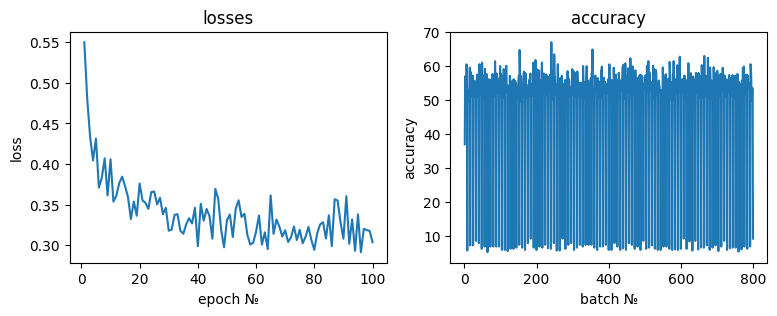

In [18]:
plot_loss_acc(losses, accuracy)

In [19]:
MODEL_PATH = '.\\titanic_net_1.pth'
torch.save(net.state_dict(), MODEL_PATH)

In [20]:
def calc_test_acc(model, data):
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in data:
            X = X.squeeze()
            y = y.squeeze()
            prob_y = model(X.float())
            y_pred = (prob_y > torch.Tensor([0.5])).long().squeeze()
            total += len(y_pred)
            correct += (y_pred == y).sum().item()
    return round((correct/total)*100, 3)

In [21]:
calc_test_acc(net, train_dataload)

86.376

In [22]:
calc_test_acc(net, val_dataload)

80.447